In [1]:
%reset -f

import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import LRScheduler
import os
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import vgg19, VGG, VGG19_Weights
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader, random_split
import tqdm
from typing import Callable
import json
import math

torch.cuda.empty_cache()

In [2]:
class UpscalerDataset(Dataset):
    def __init__(self, data:list[tuple[torch.Tensor, torch.Tensor]]):
        self.data:list[tuple[torch.Tensor, torch.Tensor]] = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> torch.Tensor:
        return self.data[idx]

def load_dataset() -> list[tuple[torch.Tensor]]:
    input_images_dir:str = os.path.join(os.getcwd(), "Dataset", "64x64")
    output_images_dir:str = os.path.join(os.getcwd(), "Dataset", "128x128")
    input_images_path:list[str] = os.listdir(input_images_dir)
    output_images_path:list[str] = os.listdir(output_images_dir)
    assert len(input_images_path) == len(output_images_path)
    dataset: list[tuple[torch.Tensor]] =  list[tuple[torch.Tensor]]()

    for image_local_path in input_images_path:
        input_image_absolute_path:str = os.path.join(input_images_dir, image_local_path)
        output_image_absolute_path:str = os.path.join(output_images_dir, image_local_path)
        input_image:torch.Tensor = torchvision.io.read_image(input_image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        output_image:torch.Tensor = torchvision.io.read_image(output_image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        dataset.append((input_image.cpu(), output_image.cpu()))

    return UpscalerDataset(dataset)

dataset:UpscalerDataset = load_dataset()

In [3]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)

        input_image:torch.Tensor = dataset[index][0]
        output_image:torch.Tensor = dataset[index][1]
        input_image = input_image.permute(1, 2, 0)
        plt.imshow(input_image)
        plt.show()
        output_image = output_image.permute(1, 2, 0)
        plt.imshow(output_image)
        plt.show()
        
# plot_dataset_image(1)

In [4]:
class UpscalerSettings:
    def __init__(self, in_channels:int=3, out_channels:int=3, num_features:int=64, num_blocks:int=16, growth_rate:int=32, num_layers:int=5, scale:int=8):
        self.in_channels:int = in_channels
        self.out_channels:int = out_channels
        self.num_features:int = num_features
        self.num_blocks:int = num_blocks
        self.growth_rate:int = growth_rate
        self.num_layers:int = num_layers
        self.scale:int = scale

in_channels:int = 3
out_channels:int = 3
num_features:int= 64
num_blocks:int= 16
growth_rate:int= 32
num_layers:int= 5
scale:int= 2
model_settings:UpscalerSettings = UpscalerSettings(in_channels, out_channels, num_features, num_blocks, growth_rate, num_layers, scale)

#training params
batch_size:int = 16
epochs:int = 400
start_lr:float = 1e-4
last_lr:float = 1e-5

start_perceptual_lambda:float = 0.001
end_perceptual_lambda:float = 0.05
def perceptual_lambda(epoch:int) -> float:
    return (float(epoch) / float(epochs)) * (end_perceptual_lambda - start_perceptual_lambda) + start_perceptual_lambda
perceptual_lambda_per_epoch:Callable[[int], float] = perceptual_lambda

test_proportion:float = 0.1

saving_epoch_interval:int = 10
print_epoch_interval:int = 10
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cuda


In [5]:
class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels:int, growth_rate:int=32, num_layers:int=5):
        super().__init__()
        self.layers:nn.ModuleList = nn.ModuleList()
        channels:int = in_channels
        for _ in range(0, num_layers):
            self.layers.append(nn.Conv2d(channels, growth_rate, kernel_size=3, stride=1, padding=1))
            channels += growth_rate
        self.lff:nn.Conv2d = nn.Conv2d(channels, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        out:torch.Tensor = x
        concat_features:torch.Tensor = x
        for conv in self.layers:
            new_feat:torch.Tensor = torch.relu(conv(concat_features))
            concat_features = torch.cat([concat_features, new_feat], dim=1)
        return self.lff(concat_features) + out

# Archi based on the Residual Dense Network for Image Super-Resolution papper
class Upscaler(nn.Module):
    def __init__(self, in_channels:int=3, out_channels:int=3, num_features:int=64, num_blocks:int=16, growth_rate:int=32, num_layers:int=5, scale:int=8):
        super().__init__()
        self.SFENet1:nn.Conv2d = nn.Conv2d(in_channels, num_features, kernel_size=3, stride=1, padding=1)
        self.SFENet2:nn.Conv2d = nn.Conv2d(num_features, num_features, kernel_size=3, stride=1, padding=1)

        self.RDBs:nn.ModuleList = nn.ModuleList([ResidualDenseBlock(num_features, growth_rate, num_layers) for _ in range(0, num_blocks)])

        self.GFF:nn.Sequential = nn.Sequential(
            nn.Conv2d(num_blocks * num_features, num_features, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(num_features, num_features, kernel_size=3, stride=1, padding=1)
        )

        log2_scalef:float = math.log2(scale)
        if int(math.floor(log2_scalef)) != int(math.ceil(log2_scalef)):
            raise ValueError(f"Scale factor must be power of 2, but got {scale}")
        
        upscale_steps:list[int] = [2 for _ in range(0, int(log2_scalef))]
        upsampler:list[nn.Module] = list[nn.Module]()
        for s in upscale_steps:
            upsampler += [
                nn.Conv2d(num_features, num_features * (s ** 2), kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(s),
                nn.ReLU(inplace=True),
                nn.Conv2d(num_features, num_features, 3, 1, 1)
            ]
        self.upsampler:nn.Sequential = nn.Sequential(*upsampler)
        self.recon:nn.Conv2d = nn.Conv2d(num_features, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        f1 = self.SFENet1(x)
        x = self.SFENet2(f1)

        rdb_outs = []
        for rdb in self.RDBs:
            x = rdb(x)
            rdb_outs.append(x)

        x = torch.cat(rdb_outs, dim=1)
        x = self.GFF(x)
        x += f1

        x = self.upsampler(x)
        x = self.recon(x)
        # x = torch.sigmoid(x) # work well with small model but not with medium
        return x

In [6]:
def load_upscaler(file:str) -> Upscaler:
    model:Upscaler = Upscaler(model_settings.in_channels, model_settings.out_channels, model_settings.num_features, model_settings.num_blocks, model_settings.growth_rate, model_settings.num_layers, model_settings.scale)
    model_path:str = os.path.join(os.getcwd(), "Models", file)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

# upscaler:Upscaler = load_upscaler("denoiser.model")

# param_size = 0
# for param in upscaler.parameters():
#     param_size += param.nelement() * param.element_size()

# size_all_mb = (param_size + 0) / (1024**2)
# print("Model size: {:.3f} MB with {} parameters".format(size_all_mb, sum(p.numel() for p in upscaler.parameters())))

In [7]:
class TrainResult:
    epoch:int
    train_losses:list[float]
    test_losses:list[float]

    @staticmethod
    def from_json(json_str:str) -> 'TrainResult':
        d = json.loads(json_str)
        return TrainResult(**d)

    def __init__(self, epoch:int, train_losses:list[float], test_losses:list[float]) -> None:
        self.epoch = epoch
        self.train_losses = train_losses
        self.test_losses = test_losses

    def to_json(self) -> str:
        return json.dumps(self.__dict__, indent=4)

In [8]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg:VGG = vgg19(weights=VGG19_Weights.DEFAULT).features[:35].eval()
        for p in vgg.parameters():
            p.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, pred:torch.Tensor, target:torch.Tensor) -> torch.Tensor:
        pred_norm:torch.Tensor = (pred - self.mean) / self.std
        target_norm:torch.Tensor = (target - self.mean) / self.std
        pred_vgg:torch.Tensor = self.vgg(pred_norm)
        target_vgg:torch.Tensor = self.vgg(target_norm)
        return self.criterion(pred_vgg, target_vgg)

In [9]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [10]:
# #training params
# batch_size:int = 24
# epochs:int = 50
# start_lr:float = 1e-5
# last_lr:float = 1e-5
# test_proportion:float = 0.1

# upscaler:Upscaler = Upscaler(in_channels=3, out_channels=3, num_features=48, num_blocks=8, growth_rate=16, num_layers=4, scale=2)
# upscaler = upscaler.to(device)
# test_size:int = int(test_proportion * len(dataset))
# train_size:int = len(dataset) - test_size
# #dataset is a list[tuple[torch.tensor, torchTensor]] where a tuple[0] is the input image (64*64) and tuple[1] is a scale image (512*512)
# #All tensor in the dataset are image in [0, 1] range
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# optimizer:torch.optim.Adam = torch.optim.Adam(upscaler.parameters(), lr=start_lr)
# scheduler:LRScheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=last_lr)
# pixel_loss_fn:nn.L1Loss = nn.L1Loss()

# for epoch in range(0, epochs):
#     train_loader:DataLoader = DataLoader(train_dataset, batch_size, shuffle=True)
#     for input_batch, output_batch in train_loader:
#         input_batch = input_batch.to(device)
#         output_batch = output_batch.to(device)
#         optimizer.zero_grad()
#         predicted_image:torch.Tensor = upscaler(input_batch)
#         loss:torch.Tensor = pixel_loss_fn(predicted_image, output_batch)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()

In [ ]:
def train(model:Upscaler) -> TrainResult:
    return resume_train(model, TrainResult(0, [], []))
    
def resume_train(model:Upscaler, train_result:TrainResult) -> TrainResult:

    sample_to_print = min(nb_sample_to_print, batch_size)
    epoch = train_result.epoch

    test_size:int = int(test_proportion * len(dataset))
    train_size:int = len(dataset) - test_size


    #For debug mode yse those 3 lines, if not debug, use only the 4 line
    # dataset2:UpscalerDataset = UpscalerDataset([dataset.data[0]])
    # train_dataset, test_dataset = random_split(dataset2, [1, 0])
    # test_dataset = train_dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


    optimizer:torch.optim.Adam = torch.optim.Adam(model.parameters(), lr=start_lr)
    scheduler:LRScheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=last_lr)
    pixel_loss_fn:nn.L1Loss = nn.L1Loss()
    perceptual_loss_fn:PerceptualLoss = PerceptualLoss().to(device)
    model.to(device)

    print("Start training Upscaler")
    with tqdm.tqdm(total=epochs * len(train_dataset), desc="Training model") as pbar:
        pbar.update(epoch * len(train_dataset))
        for epoch in range(epoch, epochs):
            train_loader:DataLoader = DataLoader(train_dataset, batch_size, shuffle=True)
            input_batch:torch.Tensor = None
            output_batch:torch.Tensor = None

            last_pred_output_batch:torch.Tensor = None
            last_output_batch:torch.Tensor = None

            total_loss:float = 0.0
            perceptual_lambda:float = perceptual_lambda_per_epoch(epoch)
            for input_batch, output_batch in train_loader:
                input_batch = input_batch.to(device)
                output_batch = output_batch.to(device)

                optimizer.zero_grad()
                predicted_image:torch.Tensor = model(input_batch)

                pixel_loss:torch.Tensor = pixel_loss_fn(predicted_image, output_batch)
                perceptual_loss:torch.Tensor = perceptual_loss_fn(predicted_image, output_batch)
                loss:torch.Tensor = pixel_loss + (perceptual_lambda * perceptual_loss)

                loss.backward()
                optimizer.step()

                total_loss += loss.cpu().item()
                last_pred_output_batch = predicted_image
                last_output_batch = output_batch
                pbar.update(input_batch.shape[0])

            scheduler.step()

            print_sample:bool = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)
            if print_sample:
                for i in range(0, sample_to_print):
                    pred_img:torch.Tensor = last_pred_output_batch[i].detach().cpu()
                    output_img:torch.Tensor = last_output_batch[i].detach().cpu()
                    print("target image :")
                    plt.imshow(output_img.permute(1, 2, 0))
                    plt.show()
                    print("Predict image :")
                    plt.imshow(pred_img.permute(1, 2, 0))
                    plt.show()

            train_loss:float = total_loss / (len(train_dataset) / batch_size)
            train_result.train_losses.append(train_loss)

            total_loss = 0.0
            test_loader:DataLoader = DataLoader(test_dataset, batch_size, shuffle=True)
            with torch.no_grad():
                for input_batch, output_batch in test_loader:
                    input_batch = input_batch.to(device)
                    output_batch = output_batch.to(device)
                    predicted_image:torch.Tensor = model(input_batch)

                    pixel_loss:torch.Tensor = pixel_loss_fn(predicted_image, output_batch)
                    perceptual_loss:torch.Tensor = perceptual_loss_fn(predicted_image, output_batch)
                    loss:torch.Tensor = pixel_loss + (perceptual_lambda * perceptual_loss)

                    total_loss += loss.cpu().item()
                train_result.test_losses.append(total_loss / (len(test_dataset) / batch_size))

            train_result.epoch = epoch

            train_res_path:str = "./Models/train_result.txt"
            file = open(train_res_path, "w")
            file.write(train_result.to_json())
            file.close()

            path:str = "./Models/upscaler.model"
            if os.path.isfile(path):
                os.remove(path)
            torch.save(model.state_dict(), path)

            save_epoch:bool = saving_epoch_interval >= 1 and ((epoch + 1) % saving_epoch_interval == 0)
            if save_epoch:
                path = f"./Models/upscaler_epoch{epoch}.model"
                if os.path.isfile(path):
                    os.remove(path)
                torch.save(model.state_dict(), path)
            
        return train_result
    
seed:int = 2442157549
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


upscaler:Upscaler = Upscaler(model_settings.in_channels, model_settings.out_channels, model_settings.num_features, model_settings.num_blocks, model_settings.growth_rate, model_settings.num_layers, model_settings.scale)
upscaler.apply(init_weights)
train_result:TrainResult = train(upscaler)

# train_res_path:str = f"./Models/train_result.txt"
# file = open(train_res_path, "r")
# string = file.read()
# train_result:TrainResult = TrainResult.from_json(string)
# file.close()
# upscaler:Upscaler = load_upscaler(f"upscaler.model")
# train_result:TrainResult = resume_train(upscaler, train_result)

Start training Upscaler


Training model:   2%|▏         | 11644/584000 [04:54<4:11:10, 37.98it/s]

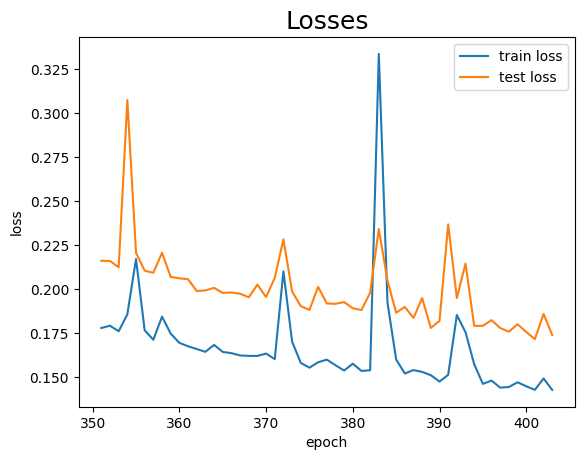

In [ ]:
def show_training_result(train_result:TrainResult, start_epoch:int=0, end_epoch:int=None) -> None:
    assert len(train_result.test_losses) == len(train_result.test_losses)
    X:list[float] = [float(i) for i in range(1, len(train_result.test_losses) + 1)]
    plt.plot(X[start_epoch:end_epoch], train_result.train_losses[start_epoch:end_epoch], label='train loss')
    plt.plot(X[start_epoch:end_epoch], train_result.test_losses[start_epoch:end_epoch], label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

train_res_path:str = f"./Models/train_result.txt"
file = open(train_res_path, "r")
train_result:TrainResult = TrainResult.from_json(file.read())
file.close()
show_training_result(train_result, 350)

Expected image : 


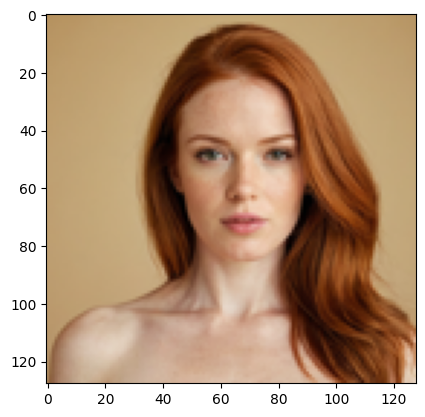

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73328817..1.4862375].


Predicted image : 


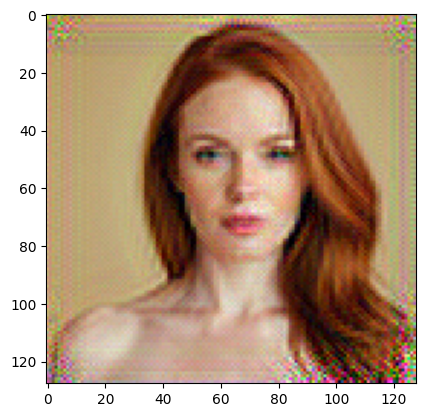

Expected image : 


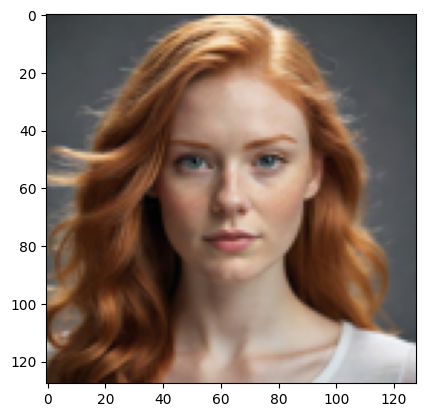

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.566701..1.5377793].


Predicted image : 


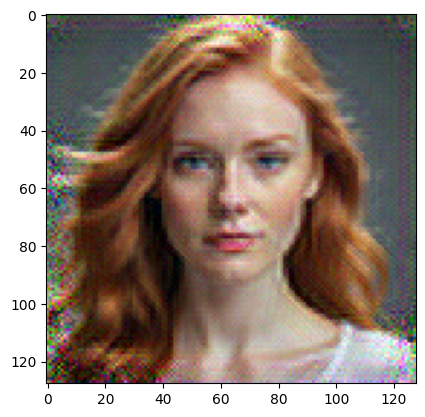

Expected image : 


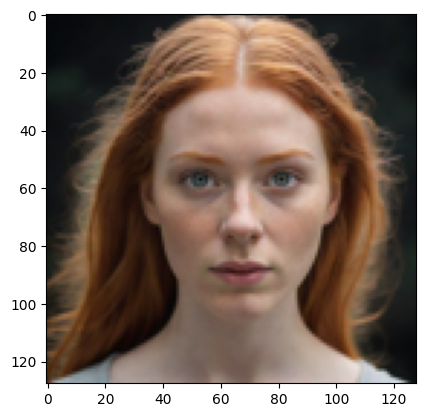

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7616354..1.243922].


Predicted image : 


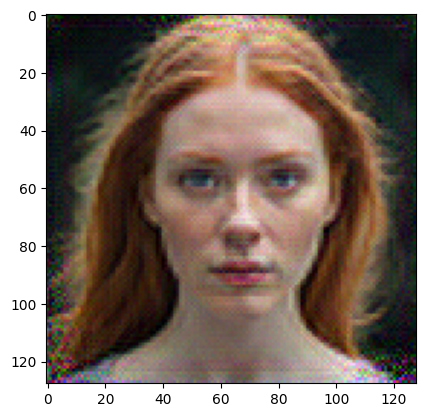

In [ ]:
def test_model(upscaler:Upscaler, test_size:int) -> None:
    upscaler.to(device)
    with torch.no_grad():
        test_data:list[tuple[torch.Tensor]] = [dataset[random.randint(0, len(dataset) - 1)] for _ in range(0, test_size)]
        input_batch:torch.Tensor = torch.stack([image[0] for image in test_data]).to(device)
        output_batch:torch.Tensor = torch.stack([image[1] for image in test_data]).to(device)
        pred_images:torch.Tensor = upscaler(input_batch)
        trans_resize:torchvision.transforms.Resize = torchvision.transforms.Resize((128, 128), InterpolationMode.BICUBIC, antialias=False)
        naive_upscales:torch.Tensor = torch.stack([trans_resize(image[0]) for image in test_data])

        for i in range(0, test_size):
            print("Expected image : ")
            plt.imshow((output_batch[i].cpu()).permute(1, 2, 0))
            plt.show()

            print("Predicted image : ")
            plt.imshow((pred_images[i].cpu()).permute(1, 2, 0))
            plt.show()

upscaler:Upscaler = load_upscaler(f"upscaler.model")
test_model(upscaler, 3)